## 튜토리얼의 흐름
- pytorch의 기본연산은 numpy의 배열 연산과 거의 동일하게 구성되어있으며, ndarray와 상호 변환이 가능하다.
  - .from_numpy, numpy() 메서드
- torch는 nn, optim, utils.data.Dataset, utils.data.DataLoader같은 유용한 클래스들을 미리 제공하는데 이것들이 어떤 역할을 하는지 다시 공부해보자.

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("/raid/jskim/data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        

(50000, 784)


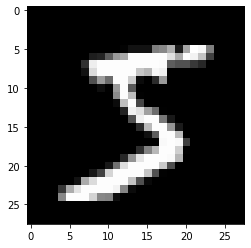

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn 없이 신경망 만들기
- weights, bias를 만들어볼것이다. 이때, 초기화는 Zavier initialisation (1/sqrt(dim of input)

In [6]:
import math


weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # grad가 있는 weights로 치환됨
bias = torch.zeros(10, requires_grad=True)

In [9]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [10]:
bs = 64  # 배치 사이즈

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.0453, -2.0530, -2.3042, -2.3469, -2.1475, -2.0749, -3.0643, -2.3590,
        -2.4082, -2.6133], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [13]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0: bs]
print(loss_func(preds, yb))

tensor(2.3620, grad_fn=<NegBackward>)


In [14]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0938)


In [16]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0834, grad_fn=<NllLossBackward>) tensor(1.)


### 위의 과정은 매우 귀찮고 반복적이다.
- 미리설정된 함수 중 가장 안바뀌는 loss 부분부터 바꿔보자.
  - 각종 loss는 torch.nn.functional에 정의되어 있다.

In [18]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0834, grad_fn=<NllLossBackward>) tensor(1.)


### nn.Module을 이용하여 모델 부분을 간소화하자
- nn.Module은 자주사용하는 속성인 parameters(), zero_grad()같은 메서드를 갖고있는 클래스이다.

In [23]:
from torch import nn
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(784, 10) / math.sqrt(784)) # 대충 눈치것 parameters는 grad를 갖는 tensor
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3093, grad_fn=<NllLossBackward>)


In [26]:
with torch.no_grad(): # 요렇게 parameters()를 호출하면 매우 편하다 참고로 지금은 loss계산이 안되서 안된다.
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()

None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [33]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward() # 요거를 model에 하위에 다 전달하는 느낌
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()


fit()

### nn.leanier 등 사전정의 layer를 사용하면 더 편리해진다.

In [34]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()

print(loss_func(model(xb), yb))

tensor(2.3515, grad_fn=<NllLossBackward>)
tensor(0.0822, grad_fn=<NllLossBackward>)


### grad 적용 또한 optimizer를 사용하면 매우 편하다.

In [35]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3676, grad_fn=<NllLossBackward>)
tensor(0.0825, grad_fn=<NllLossBackward>)


### dataset을 불러오는것도 방법이 있다.

In [36]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>)


### 느꼇겠지만 사실 TensorDataset은좀 잡스럽다. DataLoader를 쓰자

In [37]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


## Valid 과정을 추가해보자

In [38]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.4425)
1 tensor(0.2789)


## 이건 정식은 아니고 많이 쓰는 스타일의 코딩방식
- batch단위의 연산 함수와 epoch에서의 연산을 나누는것 이유는 batch연산을 trainset과 validset에 대해 모두 적용되는데 이게 중복됨

In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb) # loss랑 batch size 나중에 valid 기록용


import numpy as np


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3359074429988861
1 0.2867681453347206


## CNN으로 Mnist 튜토리얼

In [40]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1)) # view는 reahape이다

lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4328288857936859
1 0.24419014838933945


In [41]:
print(model)

Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


## View를 layer처럼 사용하는 방법도 있다.

In [42]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

# 저기 아래의 첫줄 Lambda(preprocess) 요부분이 혜자다
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33531921648979185
1 0.25266413531303406


### 참고로 transform을 적용하는건 Dataset클래스단계에서인데, dataloader까지 넘어왔으면 후처리밖에 답이없다

In [43]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### AdaptiveAvgPool 이거하면 출력사이즈를정하고 pooling해준다

In [44]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34972278962135317
1 0.24921882477402688


## gpu에서 해보자
- data batch랑 model이 둘다 to("cuda:0")같은 방식으로 gpu에 올려야 한다.

In [45]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2145486001431942
1 0.17879012581110001
